# Analysis 

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Optimization

In [27]:
distances = pd.read_csv('data/OD_Pairs_Distances.csv')
population = pd.read_excel('data/BG_master.xlsx')
bg_included = pd.read_csv('data/bg_pop_included.csv')
pod_data = pd.read_csv('data/POD_ids.csv')

scenario = pd.read_csv('data/scenario_bg_flood.csv') # flood and anthrax) 

In [29]:
scenario.tail()

,bg_id,census_geo_id,geo_id,flood,anthrax,Unnamed: 5
1095,1096,1500000US420039810001,420039810001,0,0.0,NaN
1096,1097,1500000US420039811001,420039811001,0,0.0,NaN
1097,1098,1500000US420039812001,420039812001,0,1.0,NaN
1098,1099,1500000US420039818001,420039818001,0,0.0,NaN
1099,1100,1500000US420039822001,420039822001,0,0.0,NaN


In [3]:
dist_miles = distances.pivot(index='block_group', columns='pod_id', values='Miles')
dist_time = distances.pivot(index='block_group', columns='pod_id', values='TravelTime')

In [30]:
dist = dist_miles.values                     # can change to dist_time
N = population['population'].values          # can change to num_hhs for households
prop = bg_included['all_included'].values    # can change to random_included or other column
#cap = pod_data['capacity_50'].values         # can change to other values of capacity

flood_prop = scenario['flood'].values  
anthrax_prop = scenario['anthrax'].values  

In [5]:
# Create indices
blocks = range(len(N))
pods = range(len(dist[0]))

Build model

In [7]:
m = gp.Model('POD_locations')

Using license file C:\Users\norac\gurobi.lic
Academic license - for non-commercial use only


#Add decision variables x[i] for whether a POD is opened and y[i,j] for whether POD i serves block group j

In [8]:
x = m.addVars(pods, vtype=GRB.BINARY, name='x')
y = m.addVars(blocks, pods, vtype=GRB.BINARY, name='x')

Set up objective function to minimize total distance across the population

In [9]:
obj = gp.quicksum(dist[j,i] * x[i] * y[j, i] * N[j] * prop[j] 
                  for j in blocks for i in pods)
m.setObjective(obj, GRB.MINIMIZE)

Constraint: y[i,j] can only be 1 if x[i] is also 1, meaning POD i is opened

In [10]:
m.addConstrs((y[j, i] <= x[i] for i in pods for j in blocks), name='y_if_x')

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model 

In [11]:
#Constraint: each block group must be assigned one shelter
m.addConstrs((gp.quicksum(y[j, i] for i in pods) == 1 
              for j in blocks), name='all_blocks_assigned')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [12]:
#Constrain on # of PODS
m.addConstr((gp.quicksum(x[i] for i in pods) <= 47), name='pods_opened')

<gurobi.Constr *Awaiting Model Update*>

In [13]:
#optimize model
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 52801 rows, 51747 columns and 155147 nonzeros
Model fingerprint: 0x81ca054f
Model has 51324 quadratic objective terms
Variable types: 0 continuous, 51747 integer (51747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 1.890368e+07
Presolve removed 1 rows and 0 columns
Presolve time: 0.30s
Presolved: 104124 rows, 103071 columns, 309072 nonzeros
Variable types: 0 continuous, 103071 integer (103071 binary)
Found heuristic solution: objective 2784562.6706

Explored 1 nodes (0 simplex iterations) in 2.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 2.78456e+06 1.89037e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.784562670625e+06, best bound 2.784562670625e+06, gap 0.0000%


In [14]:
block_pod_list = [[j,i] for j in blocks for i in pods if y[j, i].x==1]

In [15]:
dist_min_total = [N[j] * [dist[j,i]] for [j,i] in block_pod_list]
dist_min_total_flat = [item for sublist in dist_min_total for item in sublist]

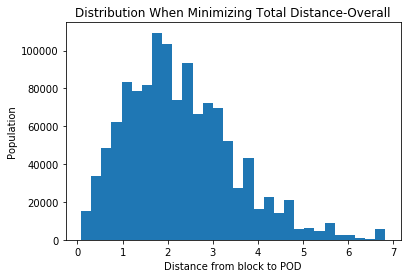

<Figure size 432x288 with 0 Axes>

In [20]:
plt.hist(dist_min_total_flat, bins=30)
plt.title('Distribution When Minimizing Total Distance-Overall')
plt.xlabel('Distance from block to POD')
plt.ylabel('Population')
plt.show()
plt.savefig('Min Total Dist.png', dpi =200)

# Now Repeat, but with Flood Data

In [31]:
# flood model 

m_f = gp.Model('POD_locations')

#Add DVs

x = m_f.addVars(pods, vtype=GRB.BINARY, name='x')
y = m_f.addVars(blocks, pods, vtype=GRB.BINARY, name='x')

#set obkective: Min total distance in flood scenario
obj = gp.quicksum(dist[j,i] * x[i] * y[j, i] * N[j] * flood_prop[j] 
                  for j in blocks for i in pods)
m_f.setObjective(obj, GRB.MINIMIZE)

# Constaints

#1  y[i,j] can only be 1 if x[i] is also 1, meaning POD i is opened
m_f.addConstrs((y[j, i] <= x[i] for i in pods for j in blocks), name='y_if_x')

#2 each block group must be assigned one shelter
m_f.addConstrs((gp.quicksum(y[j, i] for i in pods) == 1 
              for j in blocks), name='all_blocks_assigned')

#3 #Constrain on # of PODS
m_f.addConstr((gp.quicksum(x[i] for i in pods) <= 47), name='pods_opened')

#Optimize 
m_f.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 52801 rows, 51747 columns and 155147 nonzeros
Model fingerprint: 0xf1da9df1
Variable types: 0 continuous, 51747 integer (51747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [32]:
block_pod_list_flood = [[j,i] for j in blocks for i in pods if y[j, i].x==1]

In [33]:
dist_min_total_flood = [N[j] * [dist[j,i]] for [j,i] in block_pod_list_flood]
dist_min_total_flat = [item for sublist in dist_min_total_flood for item in sublist]

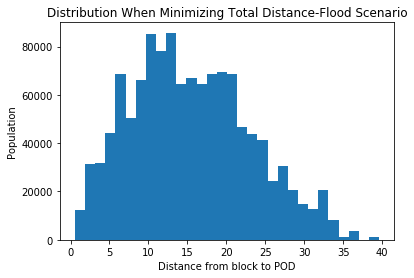

<Figure size 432x288 with 0 Axes>

In [34]:
plt.hist(dist_min_total_flat, bins=30)
plt.title('Distribution When Minimizing Total Distance-Flood Scenario')
plt.xlabel('Distance from block to POD')
plt.ylabel('Population')
plt.show()
plt.savefig('Min Total Dist:Flood Scenario.png', dpi =200)

# Now Repeat for Anthrax Scenario

In [35]:
# anthrax model 

m_a = gp.Model('POD_locations')

#Add DVs

x = m_a.addVars(pods, vtype=GRB.BINARY, name='x')
y = m_a.addVars(blocks, pods, vtype=GRB.BINARY, name='x')

#set obkective: Min total distance in flood scenario
obj = gp.quicksum(dist[j,i] * x[i] * y[j, i] * N[j] * anthrax_prop[j] 
                  for j in blocks for i in pods)
m_a.setObjective(obj, GRB.MINIMIZE)

# Constaints

#1  y[i,j] can only be 1 if x[i] is also 1, meaning POD i is opened
m_a.addConstrs((y[j, i] <= x[i] for i in pods for j in blocks), name='y_if_x')

#2 each block group must be assigned one shelter
m_a.addConstrs((gp.quicksum(y[j, i] for i in pods) == 1 
              for j in blocks), name='all_blocks_assigned')

#3 #Constrain on # of PODS
m_a.addConstr((gp.quicksum(x[i] for i in pods) <= 47), name='pods_opened')

#Optimize 
m_a.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 52801 rows, 51747 columns and 155147 nonzeros
Model fingerprint: 0xeffe8771
Model has 4606 quadratic objective terms
Variable types: 0 continuous, 51747 integer (51747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 576318.44272
Presolve removed 1 rows and 0 columns
Presolve time: 0.24s
Presolved: 57406 rows, 56353 columns, 168918 nonzeros
Variable types: 0 continuous, 56353 integer (56353 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root relaxation: objective 0.000000e+00, 4299 iterations, 0.28 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

In [40]:
block_pod_list_anthrax = [[j,i] for j in blocks for i in pods if y[j, i]]  #not for values = 1 

In [41]:
dist_min_total_anthrax = [N[j] * [dist[j,i]] for [j,i] in block_pod_list_anthrax]
dist_min_total_flat = [item for sublist in dist_min_total_anthrax for item in sublist]

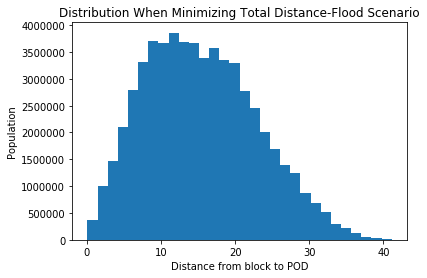

<Figure size 432x288 with 0 Axes>

In [42]:
plt.hist(dist_min_total_flat, bins=30)
plt.title('Distribution When Minimizing Total Distance-Flood Scenario')
plt.xlabel('Distance from block to POD')
plt.ylabel('Population')
plt.show()
plt.savefig('Min Total Dist:Flood Scenario.png', dpi =200)